In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
!pip install umap-learn

<IPython.core.display.Javascript object>

In [3]:
import warnings

import pandas as pd
import numpy as np
import pickle

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn import datasets, metrics
import umap

import seaborn as sns
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [4]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [5]:
df = pd.read_csv("../data/features_3_sec.csv")
df["genre"] = df["filename"].str.split(".").str[0]
df["songname"] = df["filename"].str.split(".").str[:2].str.join(".")

<IPython.core.display.Javascript object>

In [6]:
df.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

<IPython.core.display.Javascript object>

In [7]:
drop_cols = ["filename", "length", "label", "genre", "songname"]

<IPython.core.display.Javascript object>

In [8]:
X = df.drop(drop_cols, 1)
y = df["genre"]

<IPython.core.display.Javascript object>

In [9]:
X_logged = X.copy()
for c in X_logged:
    if c.endswith("_var"):
        X_logged[c] = np.log(X_logged[c])

<IPython.core.display.Javascript object>

In [10]:
scaler = StandardScaler()
std_X = scaler.fit_transform(X)

<IPython.core.display.Javascript object>

In [11]:
umap_results = umap.UMAP(
    n_neighbors=40, min_dist=0.2, metric="euclidean"
).fit_transform(std_X)

<IPython.core.display.Javascript object>

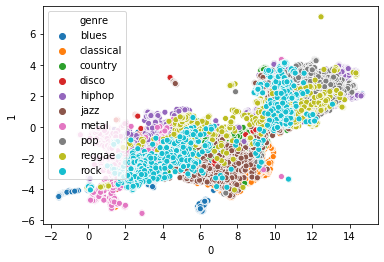

<IPython.core.display.Javascript object>

In [12]:
umap_df = pd.DataFrame(umap_results)
umap_df["genre"] = y
sns.scatterplot(x=0, y=1, hue="genre", data=umap_df)

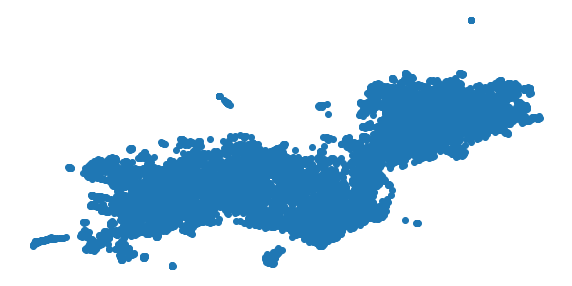

<IPython.core.display.Javascript object>

In [13]:
plt.figure(figsize=(10, 5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis("off")
plt.show()

In [23]:
umap_results = umap.UMAP(
    n_neighbors=20, min_dist=0.4, metric="euclidean", n_components=2
).fit_transform(std_X)

<IPython.core.display.Javascript object>

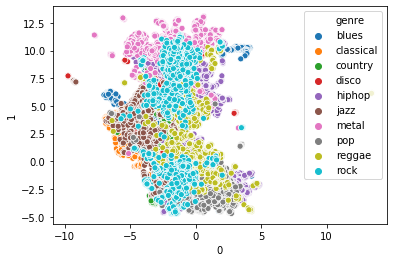

<IPython.core.display.Javascript object>

In [24]:
umap_df = pd.DataFrame(umap_results)
umap_df["genre"] = y
sns.scatterplot(x=0, y=1, hue="genre", data=umap_df)

In [25]:
clst = GaussianMixture(n_components=10)
# clst = DBSCAN(eps=3.5, min_samples=11, n_jobs=-1)
# clst = AgglomerativeClustering(n_clusters=10, affinity="cosine", linkage="complete")
# clst = KMeans(n_clusters=10, n_jobs=-1,)
clusters = clst.fit_predict(umap_results)
df["cluster"] = clusters

<IPython.core.display.Javascript object>

In [26]:
pd.Series(clusters).value_counts()

2    1681
1    1414
8    1204
9    1152
0    1091
7    1056
3     964
4     882
5     509
6      37
dtype: int64

<IPython.core.display.Javascript object>

In [27]:
umap_df["cluster"] = clusters

<IPython.core.display.Javascript object>

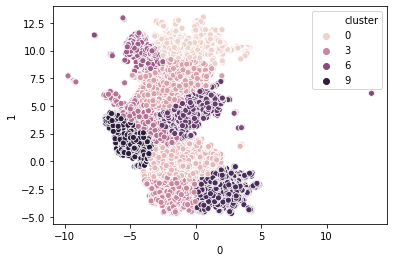

<IPython.core.display.Javascript object>

In [28]:
sns.scatterplot(x=0, y=1, hue="cluster", data=umap_df)

In [20]:
means_df = pd.DataFrame(scaler.inverse_transform(clst.means_), columns=X.columns).T
# means_df = pd.DataFrame(
#     scaler.inverse_transform(clst.cluster_centers_), columns=X.columns
# ).T
means_df.style.background_gradient()

ValueError: operands could not be broadcast together with shapes (10,2) (57,) (10,2) 

<IPython.core.display.Javascript object>

In [30]:
print(pd.crosstab(clusters, y))

genre  blues  classical  country  disco  hiphop  jazz  metal  pop  reggae  \
row_0                                                                       
0        132          0        0    113      33     2    565    0      35   
1          0         16      283    133     147   154      9  157     356   
2        292          0      307    326     195    99     90    0      43   
3          0          4      119    293      43   151      1  171       3   
4        291         93       66     17       3   371      0    1      32   
5         81          0       24     27      56     0    300    0       0   
6          0          0        0     10       0     0     11    0       7   
7        200          5      154     42     166    29     23    4     372   
8          2          0        7     32     353     2      0  656     150   
9          2        880       37      6       2   192      1   11       2   

genre  rock  
row_0        
0       211  
1       159  
2       329  
3    

<IPython.core.display.Javascript object>

In [29]:
df[df["cluster"] == 6][100:150]

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label,genre,songname,cluster


<IPython.core.display.Javascript object>